In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold ,cross_validate,RandomizedSearchCV
import xgboost as xg




In [4]:
df=pd.read_csv('../Data/HouseImformation.csv')

In [5]:
df['Area'] = df['Area'].str.replace(',', '').astype(float)

df=df.dropna()

isoOuter=IsolationForest(contamination=0.01)
df['OuterData']=isoOuter.fit_predict(df[["Area", "Price"]])

df=df.drop(index=df[df['OuterData'] == -1].index)

MeanPriceAddressOuter=df.groupby("Address")["Price"].mean()
df["MeanPriceA"] = df["Address"].map(MeanPriceAddressOuter)

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_Data = scaler.fit_transform(df[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_Data=df['Price'].values


mask= np.random.rand(len(df)) < 0.8

train=df[mask]
test=df[~mask]

x_train=np.asanyarray(train[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_train=np.asanyarray(train['Price'])

x_test=np.asanyarray(test[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_test=np.asanyarray(test['Price'])

In [7]:
model=xg.XGBRegressor(objective='reg:squarederror',eval_metric='rmse')

cv=RepeatedKFold(n_splits=100,n_repeats=3)
crossVal=cross_validate(model,x_Data,y_Data,cv=cv,scoring='r2',return_train_score=True)

print("Mean Train Score:", crossVal['train_score'].mean())
print("Mean Test Score:", crossVal['test_score'].mean())

Mean Train Score: 0.9755954733431353
Mean Test Score: 0.8255899510740392


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# جستجوی تصادفی
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,              # تعداد ترکیب‌هایی که امتحان می‌کنه
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42
)

random_search.fit(x_train, y_train)

# بهترین مدل
best_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)



Best Params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [12]:
best_params = {
    'subsample': 1.0,
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.05,
    'colsample_bytree': 1.0
}

best_model = xg.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    **best_params
)

best_model.fit(x_train, y_train)

y_predict=best_model.predict(x_test)
print("R2-score: %.2f" % r2_score(y_test , y_predict))

R2-score: 0.86


In [19]:
joblib.dump(best_model, '../Models/XGBRegressorModel.pkl')

['../Models/XGBRegressorModel.pkl']

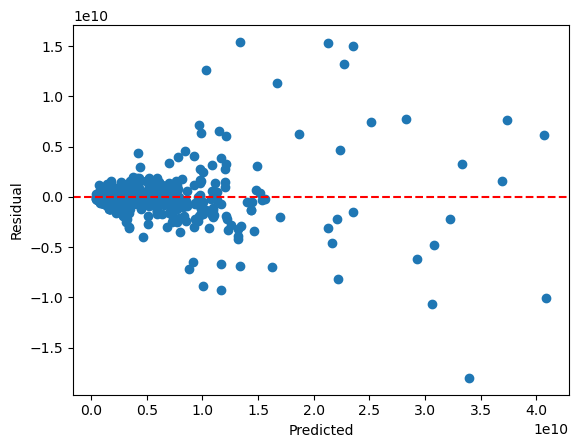

In [13]:
residuals = y_test - y_predict
plt.scatter(y_predict, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error

print("MAE:", mean_absolute_error(y_test, y_predict))

MAE: 1027910559.3674964


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predict)
mape = mean_absolute_percentage_error(y_test, y_predict)

print(f"MAE: {mae:,.0f} تومان")
print(f"RMSE: {rmse:,.0f} تومان")
print(f"R²: {r2:.2%}")
print(f"MAPE: {mape:.2%}")

MAE: 1,027,910,559 تومان
RMSE: 2,229,403,752 تومان
R²: 86.25%
MAPE: 35.08%
